# Deep Learning With Python: 5.2

**Introdução a Deep-Learning | Aplicações em Visão Computacional**

<br>

---

### Tópico abordado
- Using data augmentation to mitigate overfitting

---

<br>



In [0]:
# Imports

import os
import numpy as np
import random
import tensorflow as tf
from keras import backend as K

from google.colab import drive
import zipfile

import shutil

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import time

import matplotlib.pyplot as plt

from keras.preprocessing import image

from PIL import Image
import requests
from io import BytesIO

from IPython.core.display import display, HTML

from keras.callbacks import CSVLogger
import pandas as pd

print('Imports OK!')

Imports OK!


Using TensorFlow backend.


In [0]:
# Reprodutibilidade
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

os.environ['PYTHONHASHSEED'] = '12'
np.random.seed(123)
random.seed(1234)
tf.set_random_seed(12345)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
#                               inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

print('Sementes Plantadas!')

Sementes Plantadas!


In [0]:
# Montando Google Drive

drive.mount('/gdrive')

In [0]:
TRAIN_MODELS = False

In [0]:
class DataHandler:
  def __init__(self, folder):
    self.source_file = '/gdrive/My Drive/ml_datasets/dogs_vs_cats.zip'
    self.root_dir = '/content/data'
    self.base_dir = os.path.join(self.root_dir, folder)
    self.train_dir = os.path.join(self.base_dir, 'train')
    self.train_cats_dir = os.path.join(self.train_dir, 'cats')
    self.train_dogs_dir = os.path.join(self.train_dir, 'dogs')
    self.val_dir = os.path.join(self.base_dir, 'validation')
    self.val_cats_dir = os.path.join(self.val_dir, 'cats')
    self.val_dogs_dir = os.path.join(self.val_dir, 'dogs')
    self.test_dir = os.path.join(self.base_dir, 'test')
    self.test_cats_dir = os.path.join(self.test_dir, 'cats')
    self.test_dogs_dir = os.path.join(self.test_dir, 'dogs')
  
  def __config_dir_struct(self):
    if (not os.path.exists(self.root_dir)):
      os.mkdir(self.root_dir)

    try:
      shutil.rmtree(self.base_dir)
      print('Diretório de dados limpo')
    except:
      pass

    os.mkdir(self.base_dir)
    os.mkdir(self.train_dir)
    os.mkdir(self.train_cats_dir)
    os.mkdir(self.train_dogs_dir)
    os.mkdir(self.val_dir)
    os.mkdir(self.val_cats_dir)
    os.mkdir(self.val_dogs_dir)
    os.mkdir(self.test_dir)
    os.mkdir(self.test_cats_dir)
    os.mkdir(self.test_dogs_dir)

  def extract(self, train_samples=0, val_samples=0, test_samples=0):
    self.__config_dir_struct()

    def move_to_parent(root, child):
      for f in os.listdir(os.path.join(root, child)):
        shutil.move(
            os.path.join(root, child, f),
            root
        )
      os.rmdir(os.path.join(root, child))

    print('Iniciando descompressões')

    if (not os.path.exists(os.path.join(self.root_dir, 'train.zip'))):
      with zipfile.ZipFile(self.source_file, 'r') as zip_ref:
        zip_ref.extract('train.zip', path=self.root_dir)
        print('Conjunto de treinamento OK!')

    with zipfile.ZipFile(os.path.join(self.root_dir, 'train.zip'), 'r') as zip_ref:
      start = 0
      end = train_samples
      for i in range(start, end):
        zip_ref.extract('train/cat.{}.jpg'.format(i), path=self.train_cats_dir)
        zip_ref.extract('train/dog.{}.jpg'.format(i), path=self.train_dogs_dir)
      move_to_parent(self.train_cats_dir, 'train')
      move_to_parent(self.train_dogs_dir, 'train')
      print('Subconjunto de treinamento OK!')
      
      start = end
      end = train_samples + val_samples
      for i in range(start, end):
        zip_ref.extract('train/cat.{}.jpg'.format(i), path=self.val_cats_dir)
        zip_ref.extract('train/dog.{}.jpg'.format(i), path=self.val_dogs_dir)
      move_to_parent(self.val_cats_dir, 'train')
      move_to_parent(self.val_dogs_dir, 'train')
      print('Subconjunto de validação OK!')

      start = end
      end = train_samples + val_samples + test_samples
      for i in range(start, end):
        zip_ref.extract('train/cat.{}.jpg'.format(i), path=self.test_cats_dir)
        zip_ref.extract('train/dog.{}.jpg'.format(i), path=self.test_dogs_dir)
      move_to_parent(self.test_cats_dir, 'train')
      move_to_parent(self.test_dogs_dir, 'train')
      print('Subconjunto de teste OK!')

In [0]:
class SimpleModel:
  def __init__(self, name):
    self.train_generator = None
    self.validation_generator = None
    self.model = None
    self.history = None
    self.model_file = '/gdrive/My Drive/ml_fits/cats_dogs_{}.h5'.format(name)
    self.history_file = '/gdrive/My Drive/ml_fits/cats_dogs_{}.csv'.format(name)
  
  def preprocess(self, data_handler):
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)

    self.train_generator = train_datagen.flow_from_directory(
        data_handler.train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        shuffle=True,
        seed=1234
    )

    self.validation_generator = val_datagen.flow_from_directory(
        data_handler.val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        shuffle=True,
        seed=1234
    )

  def compile_model(self):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    
    self.model = model

  def fit(self):
    csv_logger = CSVLogger(self.history_file, separator=',', append=False)
    
    self.model.fit_generator(
        self.train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=self.validation_generator,
        validation_steps=50,
        callbacks=[csv_logger]
    )
    
    self.model.save(self.model_file)
    self.history = pd.read_csv(self.history_file, sep=',', engine='python')
    

  def load_model(self):
    self.model = models.load_model(self.model_file)
    self.history = pd.read_csv(self.history_file, sep=',', engine='python')


In [0]:
%%time
dh1 = DataHandler('subset1000')
dh1.extract(1000, 500, 500)

dh2 = DataHandler('full')
dh2.extract(8000, 4000, 500)

Iniciando descompressões
Conjunto de treinamento OK!
Subconjunto de treinamento OK!
Subconjunto de validação OK!
Subconjunto de teste OK!
Iniciando descompressões
Subconjunto de treinamento OK!
Subconjunto de validação OK!
Subconjunto de teste OK!
CPU times: user 10.3 s, sys: 4.2 s, total: 14.5 s
Wall time: 23.3 s


In [0]:
%%time
sm1 = SimpleModel('subset1000')
sm1.preprocess(dh1)

if (TRAIN_MODELS):
  sm1.compile_model()
  sm1.fit()
else:
  sm1.load_model()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


W0830 16:20:43.008091 140154558084992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 16:20:43.026994 140154558084992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 16:20:43.061970 140154558084992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0830 16:20:43.212599 140154558084992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0830 16:20:43.213920 140154558084992 deprecation_

CPU times: user 1.33 s, sys: 381 ms, total: 1.71 s
Wall time: 6.7 s


In [0]:
%%time
sm2 = SimpleModel('full')
sm2.preprocess(dh2)

if (TRAIN_MODELS):
  sm2.compile_model()
  sm2.fit()
else:
  sm2.load_model()

Found 16000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
CPU times: user 1.43 s, sys: 85.6 ms, total: 1.52 s
Wall time: 3.91 s


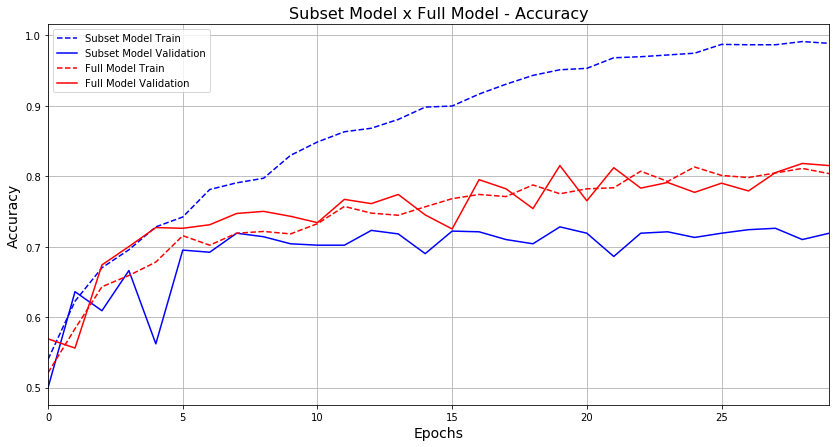

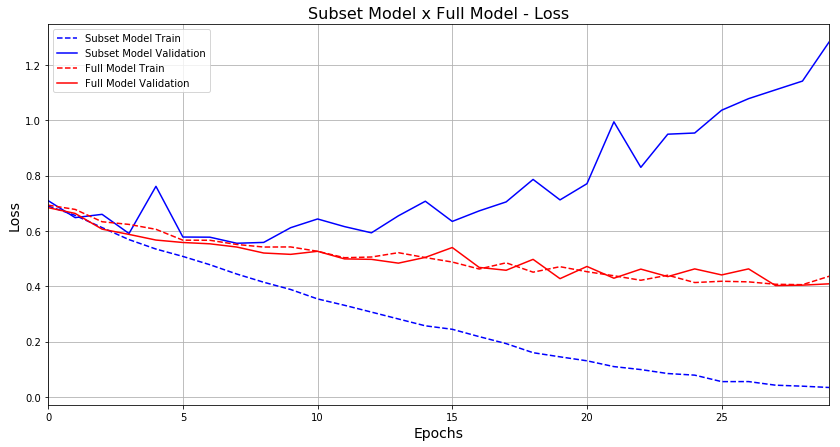

In [0]:
plt.figure(figsize=(14,7))
ax = sm1.history['acc'].plot(linestyle='--', label='Subset Model Train', color='blue')
sm1.history['val_acc'].plot(label='Subset Model Validation', color='blue')
sm2.history['acc'].plot(linestyle='--', label='Full Model Train', color='red')
sm2.history['val_acc'].plot(label='Full Model Validation', color='red')
ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Subset Model x Full Model - Accuracy', size=16)
ax.legend()
ax.grid(b=True)

plt.figure(figsize=(14,7))
ax = sm1.history['loss'].plot(linestyle='--', label='Subset Model Train', color='blue')
sm1.history['val_loss'].plot(label='Subset Model Validation', color='blue')
sm2.history['loss'].plot(linestyle='--', label='Full Model Train', color='red')
sm2.history['val_loss'].plot(label='Full Model Validation', color='red')
ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Subset Model x Full Model - Loss', size=16)
ax.legend()
ax.grid(b=True)


plt.show()

# Data Augmentation

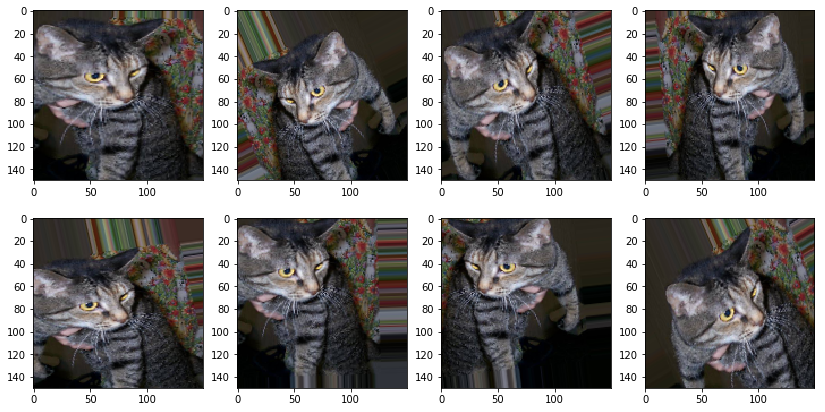

In [0]:
# Data Augmentation

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

fnames = [os.path.join(dh1.train_cats_dir, fname) for fname in os.listdir(dh1.train_cats_dir)]
img_path = fnames[254] # Chooses one image to augment
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img) # Converts to numpy array of shape (150, 150, 3)
x = x.reshape((1,) + x.shape) # Reshapes it to (1, 150, 150, 3)

i = 0
plt.figure(figsize=(14, 7))
for batch in datagen.flow(x, batch_size=1):
  plt.subplot(2, 4, i + 1)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 8 == 0:
    break
plt.show()

In [0]:
class DataAugModel:
  def __init__(self, name):
    self.train_generator = None
    self.validation_generator = None
    self.model = None
    self.history = None
    self.model_file = '/gdrive/My Drive/ml_fits/cats_dogs_{}.h5'.format(name)
    self.history_file = '/gdrive/My Drive/ml_fits/cats_dogs_{}.csv'.format(name)

  def preprocess(self, data_handler):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    self.train_generator = train_datagen.flow_from_directory(
        data_handler.train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )

    self.validation_generator = val_datagen.flow_from_directory(
        data_handler.val_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )
  
  def compile_model(self):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
    input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    self.model = model

  def fit(self, save=False):
    csv_logger = CSVLogger(self.history_file, separator=',', append=False)
    
    self.model.fit_generator(
        self.train_generator,
        steps_per_epoch=100,
        epochs=100,
        validation_data=self.validation_generator,
        validation_steps=50,
        callbacks=[csv_logger]
    )

    self.model.save(self.model_file)
    self.history = pd.read_csv(self.history_file, sep=',', engine='python')
  
  def load_model(self):
    self.model = models.load_model(self.model_file)
    self.history = pd.read_csv(self.history_file, sep=',', engine='python')

In [0]:
%%time
dam1 = DataAugModel('aug')
dam1.preprocess(dh1)
print(dam1.train_generator)

if (TRAIN_MODELS):
  dam1.compile_model()
  dam1.fit()
else:
  dam1.load_model()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 1.61 s, sys: 49.7 ms, total: 1.66 s
Wall time: 1.82 s


In [0]:
sm1_acc = np.mean(sm1.history['val_acc'])
sm2_acc = np.mean(sm2.history['val_acc'])
dam1_acc = np.mean(dam1.history['val_acc'])

print('Subset Model Accuracy: \t\t\t{0:.2f}%'.format(sm1_acc * 100))
print('Full Model Accuracy: \t\t\t{0:.2f}%'.format(sm2_acc * 100))
print('Data Augmentation Model Accuracy: \t{0:.2f}%'.format(dam1_acc * 100))
print('---')
print('Rel. Full Model x Subset: \t\t{0:.2f}%'.format(((dam1_acc / sm1_acc) - 1) * 100))
print('Rel. Full Model x Full Set: \t\t{0:.2f}%'.format(((dam1_acc / sm2_acc) - 1) * 100))

Subset Model Accuracy: 			69.24%
Full Model Accuracy: 			75.03%
Data Augmentation Model Accuracy: 	77.56%
---
Rel. Full Model x Subset: 		12.00%
Rel. Full Model x Full Set: 		3.36%


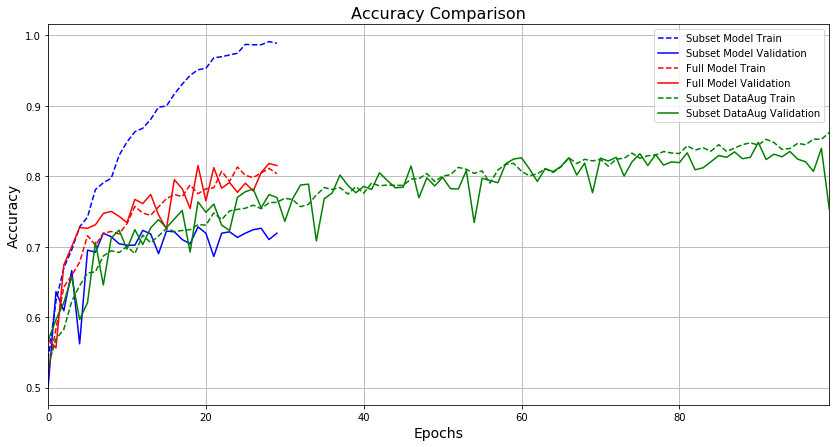

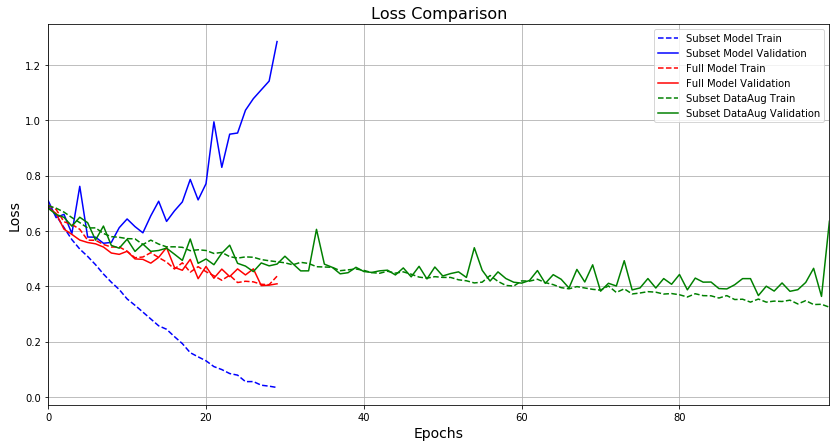

In [0]:
plt.figure(figsize=(14,7))
ax = sm1.history['acc'].plot(linestyle='--', label='Subset Model Train', color='blue')
sm1.history['val_acc'].plot(label='Subset Model Validation', color='blue')
sm2.history['acc'].plot(linestyle='--', label='Full Model Train', color='red')
sm2.history['val_acc'].plot(label='Full Model Validation', color='red')
dam1.history['acc'].plot(linestyle='--', label='Subset DataAug Train', color='green')
dam1.history['val_acc'].plot(label='Subset DataAug Validation', color='green')
ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy Comparison', size=16)
ax.legend()
ax.grid(b=True)

plt.figure(figsize=(14,7))
ax = sm1.history['loss'].plot(linestyle='--', label='Subset Model Train', color='blue')
sm1.history['val_loss'].plot(label='Subset Model Validation', color='blue')
sm2.history['loss'].plot(linestyle='--', label='Full Model Train', color='red')
sm2.history['val_loss'].plot(label='Full Model Validation', color='red')
dam1.history['loss'].plot(linestyle='--', label='Subset DataAug Train', color='green')
dam1.history['val_loss'].plot(label='Subset DataAug Validation', color='green')
ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss Comparison', size=16)
ax.legend()
ax.grid(b=True)

plt.show()

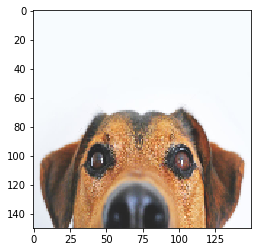

In [0]:
#@title #Predição com imagens da internet { vertical-output: true }
url = 'https://images.pexels.com/photos/406014/pexels-photo-406014.jpeg?auto=compress&cs=tinysrgb&h=750&w=1260' #@param {type:"string"}
model = dam1 #@param ["dam1", "sm1", "sm2"] {type:"raw"}

def get_image(url):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content)) \
             .resize((150, 150), resample=Image.NEAREST)
  pixels = list(img.getdata())
  w, h = img.size
  pixels = [pixels[i * w:(i + 1) * w] for i in range(h)]
  return pixels

def preprocess(img):
  data = np.array(img)
  data = data.reshape((1, 150, 150, 3))
  data = data.astype('float32') / 255
  return data

def get_predictions(model, data):
  classes = ['CAT', 'DOG']
  return classes[model.model.predict_classes(data)[0][0]]

def get_response(r):
  j = '''
  <div style="width:280px; background-color:red; 
              color:white; text-align:center;
              font-size: 20px; font-weight:bold;
              letter-spacing: 12px;">
  {}
  </div>
  '''
  return j.format(r)

def main():
  if len(url) < 1:
    return
  
  img = get_image(url)
  
  plt.figure(figsize=(4, 4))
  plt.imshow(img)
  plt.show()

  img = preprocess(img)

  display(HTML(get_response(get_predictions(model, img))))
  
main()